In [87]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import pytorch_lightning as pl

%matplotlib inline

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE = 512
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count()/2)

In [88]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="data", batch_size=32, num_workers=0):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)


In [89]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [90]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)
        self.ct1 = nn.ConvTranspose2d(64,32,4,stride = 2)
        self.ct2 = nn.ConvTranspose2d(32,16,4,stride = 2)
        self.conv = nn.Conv2d(16, 1, kernel_size=7)

    def forward(self, x):
        x=self.lin1(x)
        x=F.relu(x)
        x=x.view(-1,64,7,7)

        x=self.ct1(x)
        x=F.relu(x)

        x=self.ct2(x)
        x=F.relu(x)

        return self.conv(x)

In [99]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim= self.hparams.latent_dim)
        self.discriminator = Discriminator()
        self.automatic_optimization = False

        self.validation_z = torch.randn(6, self.hparams.latent_dim)
    
    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        opt1, opt2 = self.optimizers()
        real_imgs, _ = batch
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        if opt1:
            fake_imgs = self(z)
            y_hat = self.discriminator(fake_imgs)
            y = torch.ones(real_imgs.size(0), 1)
            y = y.type_as(real_imgs)

            g_loss = self.adversarial_loss(y_hat, y)
            log_dict = {"g_loss": g_loss}
            return {"loss": g_loss, "progress_bar": log_dict, "log":log_dict}
        
        if opt2:
            y_hat_real = self.discriminator(real_imgs)
            y_real = torch.ones(real_imgs.size(0), 1)
            y_real = y_real.type_as(real_imgs)

            real_loss = self.adversarial_loss(y_hat_real, y_real)
            y_hat_fake = self.discriminator(self(z).detach())

            y_fake = torch.zeros(real_imgs.size(0), 1)
            y_fake = y_fake.type_as(real_imgs)

            fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
            d_loss = real_loss + fake_loss
            log_dict = {"d_loss": d_loss}
            return {"loss": d_loss, "progress_bar": log_dict, "log":log_dict}

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []
    
    # def plot_images(self):
    #     z = self.validation_z.type_as(self.generator.lin1.weight)
    #     sample_imgs = self(z).cpu()

    #     print("epoch", self.current_epoch)
    #     fig = plt.figure()
    #     for i in range(sample_imgs.size(0)):
    #         plt.subplot(2,3,i+1)
    #         plt.tight_layout()
    #         plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap="gray_r", interpolation="none")
    #         plt.title("Generated_data")
    #         plt.xticks([])
    #         plt.yticks([])
    #         plt.axis("off")
    #         plt.imsave(f"epoch-{self.current_epoch}.jpg", sample_imgs.detach()[i, 0, :, :])
    #     plt.show()
    def plot_images(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        print("epoch", self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2,3,i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap="gray_r", interpolation="none")
            plt.title("Generated_data")
            plt.xticks([])
            plt.yticks([])
            plt.axis("off")
            plt.imsave(f"epoch-{self.current_epoch}-img{i}.jpg", sample_imgs.detach()[i, 0, :, :])

        plt.close(fig)  # Close the figure to prevent it from being displayed

    
    def on_epoch_end(self):
        self.plot_images()

In [100]:
dm = MNISTDataModule()
dm.prepare_data()
dm.setup()
model = GAN()

epoch 0
Epoch 4:  77%|███████▋  | 1316/1719 [05:45<01:45,  3.81it/s, v_num=10]


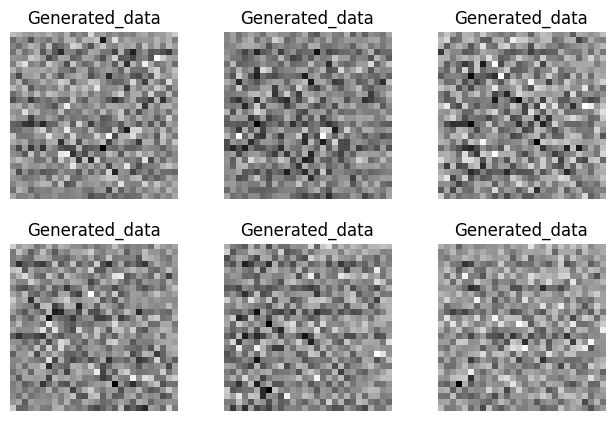

In [101]:
model.plot_images()

In [102]:
trainer = pl.pytorch_lightning.Trainer(max_epochs=20, accelerator="gpu")
# model.on_epoch_end()
trainer.fit(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


d:\windowsps_backup\GenAI\GAN_Pytorch\venv\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
d:\windowsps_backup\GenAI\GAN_Pytorch\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 5:  59%|█████▊    | 1009/1719 [00:11<00:08, 84.90it/s, v_num=12]

d:\windowsps_backup\GenAI\GAN_Pytorch\venv\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
